In [ ]:
# -------------------------------
# 1️⃣ Uninstall conflicting versions
# -------------------------------
!pip uninstall -y torch torchtext torchvision torchaudio numpy

# -------------------------------
# 2️⃣ Install compatible versions
# For vanilla RNN + IMDB
# torch 2.3.0, torchtext 0.18.0, torchvision/torchaudio matching
# numpy 1.26.4 (avoids PyTorch errors)
# -------------------------------
!pip install torch==2.3.0 torchtext==0.18.0 torchvision==0.18.0 torchaudio==2.3.0 numpy==1.26.4 --quiet

# -------------------------------
# 3️⃣ Restart runtime (required to load new versions)
# -------------------------------

import os
os.kill(os.getpid(), 9)  # This forces Colab to restart


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('emotions.csv')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [55]:
import re

def clean_text(text):
  text = re.sub(r'http\s+', '', text)
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'[^A-Za-z\s]', '', text)
  return text.lower().strip()

df['new'] = df['content'].astype(str).apply(clean_text)

In [56]:
texts = df['new'].tolist()
labels = df['sentiment'].tolist()

In [57]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
print(num_classes)

13


In [58]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
  for text in data_iter:
    yield tokenizer(text)

In [59]:
vocab = build_vocab_from_iterator(yield_tokens(texts), specials = ['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])
pad_idx = vocab['<pad>']

In [60]:
class emotions(Dataset):
  def __init__(self, texts, labels, vocab, tokenizer, max_len = 50):
    self.texts = texts
    self.labels = labels
    self.vocab = vocab
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    tokens = self.vocab(self.tokenizer(self.texts[idx]))
    if len(tokens) < self.max_len:
      tokens += [pad_idx] * (self.max_len - len(tokens))
    else:
      tokens = tokens[:self.max_len]

    text = torch.tensor(tokens, dtype = torch.long)
    label = torch.tensor(self.labels[idx], dtype = torch.long)
    return text, label

In [61]:
x_train, x_test, y_train, y_test = train_test_split(texts, labels, test_size = 0.4, random_state = 42)
trainset = emotions(x_train, y_train, vocab, tokenizer)
testset = emotions(x_test, y_test, vocab, tokenizer)

train_loader = DataLoader(trainset, batch_size = 25, shuffle = True)
test_loader = DataLoader(testset, batch_size = 25, shuffle = False)

In [72]:
import torch.nn.functional as F

class Bilstm(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout = 0.3):
    super(Bilstm, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = pad_idx)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional = True, batch_first = True, dropout = dropout)
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(hidden_dim * 2, output_dim)

    self.attention = nn.Linear(hidden_dim * 2, 1)

  def forward(self, x, return_attn=False):
    embedded = self.embedding(x)
    output, _ = self.lstm(embedded)

    attn_weights = F.softmax(self.attention(output), dim = 1)

    context = torch.sum(attn_weights * output, dim = 1)

    context = self.dropout(context)
    logits = self.fc(context)

    if return_attn:
      return logits, attn_weights.squeeze(-1)
    return logits

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [77]:
model = Bilstm(len(vocab), embed_dim=110, hidden_dim=128, output_dim=num_classes, dropout=0.4).to(device)

In [81]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-5)

In [82]:
epochs = 10
for epoch in range(epochs):
  model.train()
  total_loss = 0
  total_correct, total_true = 0.0, 0.0
  for texts, labels in train_loader:
    texts, labels = texts.to(device), labels.to(device)
    opt.zero_grad()
    output = model(texts)
    loss = loss_fn(output, labels)

    loss.backward()
    opt.step()

    total_loss += loss.item()

    preds = torch.argmax(output, dim =1)

    total_correct += (preds == labels).sum().item()
    total_true += labels.size(0)

  acc = 100 * total_correct / total_true

  print(f'Epoch : {epoch+1}, Loss : {total_loss/len(train_loader)}')
  print(f'Accuracy : {acc:.2f}%')



Epoch : 1, Loss : 1.4700760879553854
Accuracy : 49.97%
Epoch : 2, Loss : 0.9907594870465497
Accuracy : 67.46%
Epoch : 3, Loss : 0.6754051432479173
Accuracy : 78.34%
Epoch : 4, Loss : 0.5020334970516463
Accuracy : 84.02%
Epoch : 5, Loss : 0.40570681776540973
Accuracy : 86.83%
Epoch : 6, Loss : 0.3419821285021802
Accuracy : 88.91%
Epoch : 7, Loss : 0.2995711108883067
Accuracy : 90.26%
Epoch : 8, Loss : 0.26727934773274076
Accuracy : 91.32%
Epoch : 9, Loss : 0.24034084288481003
Accuracy : 92.10%
Epoch : 10, Loss : 0.2295010178631249
Accuracy : 92.33%


In [103]:
import torch
import matplotlib.pyplot as plt

def visualize_attention(model, sentence, vocab, tokenizer, device, pad_idx=0, max_len=50):
    model.eval()

    # Tokenize into words
    words = tokenizer(sentence)

    # Convert words to IDs
    token_ids = [vocab[word] if word in vocab else vocab['<UNK>'] for word in words]


    # Pad / truncate
    if len(token_ids) < max_len:
        token_ids += [pad_idx] * (max_len - len(token_ids))
        words += ['<PAD>'] * (max_len - len(words))   # keep words aligned
    else:
        token_ids = token_ids[:max_len]
        words = words[:max_len]

    # Convert to tensor
    input_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(device)

    # Forward pass with attention
    with torch.no_grad():
        output, attn_weights = model(input_tensor, return_attn=True)
        pred_class = torch.argmax(output, dim=1).item()

    # Extract attention weights
    attn_weights = attn_weights.squeeze(0).cpu().numpy()

    # Plot
    plt.figure(figsize=(12, 3))
    plt.bar(words, attn_weights, color='skyblue')
    plt.xticks(rotation=45)
    plt.title(f'Predicted class: {pred_class}')
    plt.show()


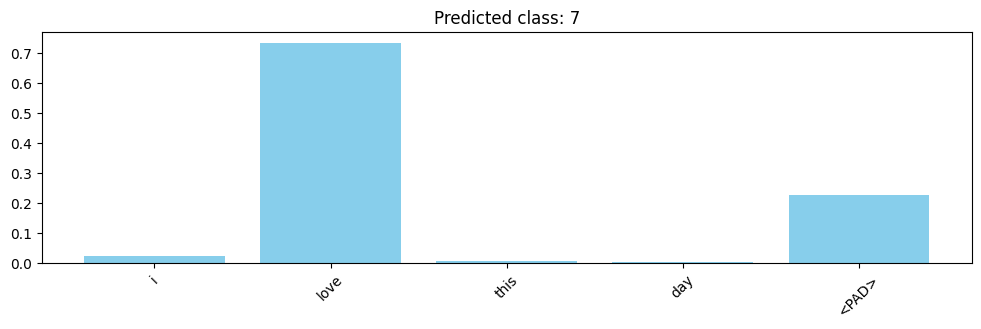

In [106]:
sentence = "I love this day"
visualize_attention(model, sentence, vocab, tokenizer, device, pad_idx = 0 ,max_len = 50)